In [63]:
import pandas as pd
import numpy as np
import re
import os

import seaborn as sns
import matplotlib.pyplot as plt

### 0. Imports and Utils

In [64]:
# Let's define some hyper-parameters
hparams = {
  'output_data_path': 'C:\\Users\\danie\\Documents\\TFM\\tfm\\output_data\\gpt2_wav2vec2_fede_asr_transcript',
  'audio_embedding_model': 'wav2vec2_fede_asr',
}

In [65]:
def load_train_logs(input_path):

    data_dict = {}

    loss_pattern = r"Loss: (\d+\.\d+)"
    avg_loss_pattern = r"Avg Loss: (\d+\.\d+)"
    avg_acc_pattern = r"Avg Acc: (\d+\.\d+)%"
    avg_urs_pattern = r"Avg URS: (\d+\.\d+)%"

    text_seeds_folders = os.listdir(input_path)

    for text_seed_folder in text_seeds_folders:
        text_seed_folder = os.path.join(input_path, text_seed_folder)
        experiments_folders = os.listdir(text_seed_folder)
        
        for experiment_folder in experiments_folders:
            experiment_name = experiment_folder
            experiment_folder = os.path.join(text_seed_folder, experiment_folder)

            experiment_data = {'loss': list(),
                                'avg_loss': list(),
                                'avg_acc': list(),
                                'avg_urs': list()}

            with open(experiment_folder + '\\train.log') as f:
                
                lines = [line.rstrip() for line in f]

                for line in lines:
                    if 'Train Epoch' not in line:
                        continue
                    
                    loss_match = re.search(loss_pattern, line).group(1)
                    experiment_data['loss'].append(float(loss_match))

                    avg_loss_match = re.search(avg_loss_pattern, line).group(1)
                    experiment_data['avg_loss'].append(float(avg_loss_match))

                    avg_acc_match = re.search(avg_acc_pattern, line).group(1)
                    experiment_data['avg_acc'].append(float(avg_acc_match))

                    avg_urs_match = re.search(avg_urs_pattern, line).group(1)
                    experiment_data['avg_urs'].append(float(avg_urs_match))

            data_dict[experiment_name] = experiment_data
                
    return data_dict

In [66]:
def load_metrics_logs(input_path):

    data_dict = {}

    pattern_list = r"([\w_]+):\s?(\[.*?\])"
    pattern_value = r"([\w_]+):\s?(\d+\.\d+)"

    text_seeds_folders = os.listdir(input_path)

    for text_seed_folder in text_seeds_folders:
        text_seed_folder = os.path.join(input_path, text_seed_folder)
        experiments_folders = os.listdir(text_seed_folder)
        
        for experiment_folder in experiments_folders:
            experiment_name = experiment_folder
            experiment_folder = os.path.join(text_seed_folder, experiment_folder)

            experiment_data = dict()

            with open(experiment_folder + '\\metrics.log') as f:
                lines = [line.rstrip() for line in f]

                for line in lines:
                    # Extract values using regular expressions
                    matches = re.findall(pattern_list, line)
                    
                    # Store values in dictionaries
                    for key, value in matches:
                        value = eval(value)
                        experiment_data[key] = value

                    # Extract values using regular expressions
                    matches = re.findall(pattern_value, line)
                    
                    # Store values in dictionaries
                    for key, value in matches:
                        value = eval(value)
                        experiment_data[key] = value
                    
            data_dict[experiment_name] = experiment_data
                
    return data_dict

In [67]:
# Define the confidence level (e.g., 95%)
confidence_level = 0.95
z_score = 1.96  # For 95% confidence interval

def get_mean_with_margin_evolution(data):
    
    global confidence_level, z_score

    # Calculate the mean and standard deviation across experiments for each time point
    mean_data = np.mean(data, axis=0)
    std_data = np.std(data, axis=0)

    # Calculate the margin of error
    margin_of_error = z_score * (std_data / np.sqrt(len(data)))

    return mean_data, margin_of_error

In [68]:
def plot_text_audio_metric_evolution(mean_metric_gpt2, margin_of_error_gpt2,
                                     mean_metric_audio, margin_of_error_audio,
                                     label_gpt='Average GPT2 Only',
                                     label_audio='Average GPT2 & W2V2',
                                     x_axis_label='Iterations',
                                     y_axis_label='Cross-Entropy Loss',
                                     title='Loss evolution'):
    
    if len(mean_metric_gpt2) > 0:
        # Plot the average line
        plt.plot(np.concatenate((mean_metric_gpt2, mean_metric_audio)), label=label_audio, color='red')
        # Plot the confidence interval
        plt.fill_between(range(len(np.concatenate((mean_metric_gpt2, mean_metric_audio)))),
                        np.concatenate((mean_metric_gpt2, mean_metric_audio)) - np.concatenate((margin_of_error_gpt2, margin_of_error_audio)),
                        np.concatenate((mean_metric_gpt2, mean_metric_audio)) + np.concatenate((margin_of_error_gpt2, margin_of_error_audio)),
                        color='red', alpha=0.20,)

        # Plot the average line
        plt.plot(mean_metric_gpt2, label=label_gpt, color='blue')
        # Plot the confidence interval
        plt.fill_between(range(len(mean_metric_gpt2)), mean_metric_gpt2 - margin_of_error_gpt2, mean_metric_gpt2 + margin_of_error_gpt2,
                        color='blue', alpha=0.20,)
    else:
        # Plot the average line
        plt.plot(mean_metric_audio, label=label_audio, color='red')
        # Plot the confidence interval
        plt.fill_between(range(len(mean_metric_audio)),
                        mean_metric_audio - margin_of_error_audio,
                        mean_metric_audio + margin_of_error_audio,
                        color='red', alpha=0.20,)

    # Add labels and legend
    plt.ylim(ymin=0)  # this line
    plt.xlim(xmin=0)  # this line
    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)
    plt.title(title)
    plt.grid()
    plt.legend()

    # Show the plot
    plt.show()

### 1. Load data

#### 1.1. Load results using audio embedding

In [69]:
train_dict = load_train_logs(hparams['output_data_path'])

In [70]:
print("Experiments found:")
l_found = list(train_dict.keys())
for key in train_dict.keys():
    print(key)

Experiments found:
1.2.gpt2_wav2vec2_asr_fede_seed_0
1.1.gpt2_wav2vec2_asr_fede_seed_42
1.3.gpt2_wav2vec2_asr_fede_seed_84


In [71]:
metrics_dict = load_metrics_logs(hparams['output_data_path'])

In [72]:
assert set(l_found) == set(metrics_dict.keys())

### 1. Loss evolution during training

In [73]:
loss_all_experiments_audio = [np.array(train_dict[key]['loss']) for key in train_dict]
loss_all_experiments_audio = np.array(loss_all_experiments_audio)

mean_loss_audio, margin_of_error_audio = get_mean_with_margin_evolution(loss_all_experiments_audio)

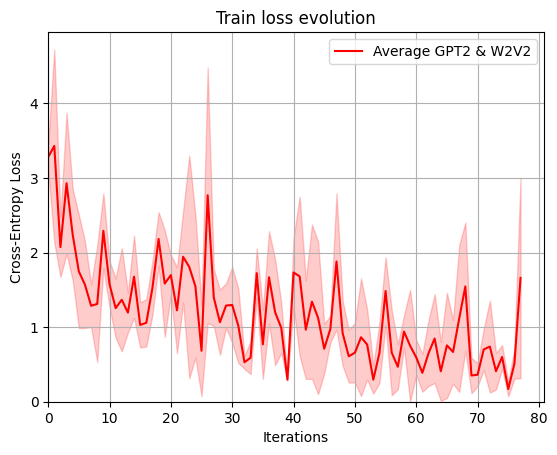

In [74]:
plot_text_audio_metric_evolution([], [],
                                 mean_loss_audio, margin_of_error_audio,
                                 title='Train loss evolution',
                                 x_axis_label='Iterations',
                                 y_axis_label='Cross-Entropy Loss')

### 2. Accuracy evolution during training

In [75]:
loss_all_experiments_audio = [np.array(train_dict[key]['avg_acc']) for key in train_dict]
loss_all_experiments_audio = np.array(loss_all_experiments_audio)

mean_loss_audio, margin_of_error_audio = get_mean_with_margin_evolution(loss_all_experiments_audio)

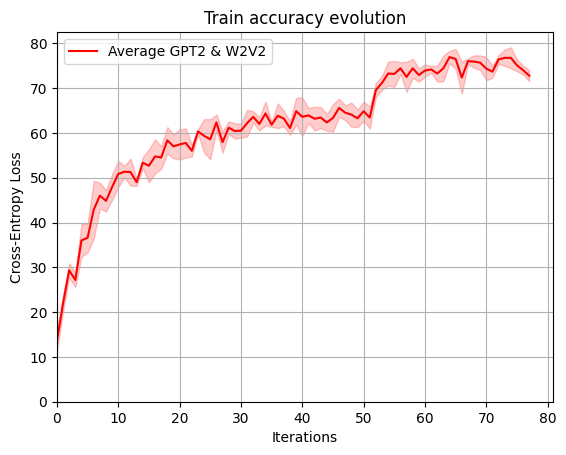

In [76]:
plot_text_audio_metric_evolution([], [],
                                 mean_loss_audio, margin_of_error_audio,
                                 title='Train accuracy evolution',
                                 x_axis_label='Iterations',
                                 y_axis_label='Cross-Entropy Loss')

### 3. URS evolution during training

In [77]:
loss_all_experiments_audio = [np.array(train_dict[key]['avg_urs']) for key in train_dict]
loss_all_experiments_audio = np.array(loss_all_experiments_audio)

mean_loss_audio, margin_of_error_audio = get_mean_with_margin_evolution(loss_all_experiments_audio)

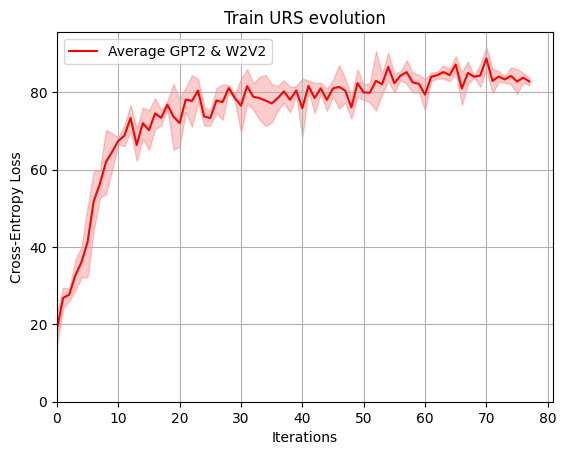

In [78]:
plot_text_audio_metric_evolution([], [],
                                 mean_loss_audio, margin_of_error_audio,
                                 title='Train URS evolution',
                                 x_axis_label='Iterations',
                                 y_axis_label='Cross-Entropy Loss')

### 3.1. Loss

In [79]:
loss_all_experiments_audio = [np.array(metrics_dict[key]['train_loss'][-1]) for key in train_dict]
loss_all_experiments_audio = np.array(loss_all_experiments_audio)

print(f"mean train loss gpt2 + {hparams['audio_embedding_model']}: {np.mean(np.mean(loss_all_experiments_audio))}. std: {np.std(loss_all_experiments_audio)}")

mean train loss gpt2 + wav2vec2_fede_asr: 0.7391241696007848. std: 0.01339049249527487


In [80]:
with open(f"{hparams['audio_embedding_model']}_output.txt", 'a') as file:
    file.write(f'mean_train_loss: {np.mean(np.mean(loss_all_experiments_audio))}\n')
    file.write(f'std_train_loss: {np.std(loss_all_experiments_audio)}\n')

In [81]:
loss_all_experiments_audio = [np.array(metrics_dict[key]['dev_loss'][-1]) for key in train_dict]
loss_all_experiments_audio = np.array(loss_all_experiments_audio)

print(f"mean train loss gpt2 + {hparams['audio_embedding_model']}: {np.mean(np.mean(loss_all_experiments_audio))}. std: {np.std(loss_all_experiments_audio)}")

mean train loss gpt2 + wav2vec2_fede_asr: 1.0342309696333747. std: 0.04144136250966775


In [82]:
with open(f"{hparams['audio_embedding_model']}_output.txt", 'a') as file:
    file.write(f'mean_dev_loss: {np.mean(np.mean(loss_all_experiments_audio))}\n')
    file.write(f'std_dev_loss: {np.std(loss_all_experiments_audio)}\n')

In [83]:
loss_all_experiments_audio = [np.array(metrics_dict[key]['test_loss']) for key in train_dict]
loss_all_experiments_audio = np.array(loss_all_experiments_audio)

print(f"mean train loss gpt2 + {hparams['audio_embedding_model']}: {np.mean(np.mean(loss_all_experiments_audio))}. std: {np.std(loss_all_experiments_audio)}")

mean train loss gpt2 + wav2vec2_fede_asr: 3.247154221390233. std: 0.046788395872520504


In [84]:
with open(f"{hparams['audio_embedding_model']}_output.txt", 'a') as file:
    file.write(f'mean_test_loss: {np.mean(np.mean(loss_all_experiments_audio))}\n')
    file.write(f'std_test_loss: {np.std(loss_all_experiments_audio)}\n')

### 3.2. Accuracy

In [85]:
loss_all_experiments_audio = [np.array(metrics_dict[key]['train_accuracy'][-1]) for key in train_dict]
loss_all_experiments_audio = np.array(loss_all_experiments_audio)

print(f"mean train loss gpt2 + {hparams['audio_embedding_model']}: {np.mean(np.mean(loss_all_experiments_audio))}. std: {np.std(loss_all_experiments_audio)}")

mean train loss gpt2 + wav2vec2_fede_asr: 74.27719821162445. std: 0.4276464435434078


In [86]:
with open(f"{hparams['audio_embedding_model']}_output.txt", 'a') as file:
    file.write(f'mean_train_accuracy: {np.mean(np.mean(loss_all_experiments_audio))}\n')
    file.write(f'std_train_accuracy: {np.std(loss_all_experiments_audio)}\n')

In [87]:
loss_all_experiments_audio = [np.array(metrics_dict[key]['dev_accuracy'][-1]) for key in train_dict]
loss_all_experiments_audio = np.array(loss_all_experiments_audio)

print(f"mean train loss gpt2 + {hparams['audio_embedding_model']}: {np.mean(np.mean(loss_all_experiments_audio))}. std: {np.std(loss_all_experiments_audio)}")

mean train loss gpt2 + wav2vec2_fede_asr: 66.30688448074679. std: 0.30409365560310964


In [88]:
with open(f"{hparams['audio_embedding_model']}_output.txt", 'a') as file:
    file.write(f'mean_dev_accuracy: {np.mean(np.mean(loss_all_experiments_audio))}\n')
    file.write(f'std_dev_accuracy: {np.std(loss_all_experiments_audio)}\n')

In [89]:
loss_all_experiments_audio = [np.array(metrics_dict[key]['test_accuracy']) for key in train_dict]
loss_all_experiments_audio = np.array(loss_all_experiments_audio)

print(f"mean train loss gpt2 + {hparams['audio_embedding_model']}: {np.mean(np.mean(loss_all_experiments_audio))}. std: {np.std(loss_all_experiments_audio)}")

mean train loss gpt2 + wav2vec2_fede_asr: 45.03210608305787. std: 0.9622358895455925


In [90]:
with open(f"{hparams['audio_embedding_model']}_output.txt", 'a') as file:
    file.write(f'mean_test_accuracy: {np.mean(np.mean(loss_all_experiments_audio))}\n')
    file.write(f'std_test_accuracy: {np.std(loss_all_experiments_audio)}\n')

### 3.3.URS

In [91]:
loss_all_experiments_audio = [np.array(metrics_dict[key]['train_urs'][-1]) for key in train_dict]
loss_all_experiments_audio = np.array(loss_all_experiments_audio)

print(f"mean train loss gpt2 + {hparams['audio_embedding_model']}: {np.mean(np.mean(loss_all_experiments_audio))}. std: {np.std(loss_all_experiments_audio)}")

mean train loss gpt2 + wav2vec2_fede_asr: 83.85030652392716. std: 0.21998014969661422


In [92]:
with open(f"{hparams['audio_embedding_model']}_output.txt", 'a') as file:
    file.write(f'mean_train_urs: {np.mean(np.mean(loss_all_experiments_audio))}\n')
    file.write(f'std_train_urs: {np.std(loss_all_experiments_audio)}\n')

In [93]:
loss_all_experiments_audio = [np.array(metrics_dict[key]['dev_urs'][-1]) for key in train_dict]
loss_all_experiments_audio = np.array(loss_all_experiments_audio)

print(f"mean train loss gpt2 + {hparams['audio_embedding_model']}: {np.mean(np.mean(loss_all_experiments_audio))}. std: {np.std(loss_all_experiments_audio)}")

mean train loss gpt2 + wav2vec2_fede_asr: 83.67697594501719. std: 1.8439129475378317


In [94]:
with open(f"{hparams['audio_embedding_model']}_output.txt", 'a') as file:
    file.write(f'mean_dev_urs: {np.mean(np.mean(loss_all_experiments_audio))}\n')
    file.write(f'std_dev_urs: {np.std(loss_all_experiments_audio)}\n')

In [95]:
loss_all_experiments_audio = [np.array(metrics_dict[key]['test_urs']) for key in train_dict]
loss_all_experiments_audio = np.array(loss_all_experiments_audio)

print(f"mean train loss gpt2 + {hparams['audio_embedding_model']}: {np.mean(np.mean(loss_all_experiments_audio))}. std: {np.std(loss_all_experiments_audio)}")

mean train loss gpt2 + wav2vec2_fede_asr: 81.78926441351888. std: 2.2801947363913833


In [96]:
with open(f"{hparams['audio_embedding_model']}_output.txt", 'a') as file:
    file.write(f'mean_test_urs: {np.mean(np.mean(loss_all_experiments_audio))}\n')
    file.write(f'std_test_urs: {np.std(loss_all_experiments_audio)}\n')